<a href="https://colab.research.google.com/github/StevieG47/mustachify/blob/master/mustachify_example_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import torch
import cv2
import PIL
from diffusers import StableDiffusionInpaintPipeline
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageOps
from torchvision.utils import save_image
from diffusers import StableDiffusionInpaintPipeline
import matplotlib.pyplot as plt
%matplotlib inline
import dlib
import time
import os
import requests
from io import BytesIO

# Helper Functions

In [ ]:
def distance(p0, p1):
    return np.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

# inputs: path to shape_predictor_68_face_landmarks.dat
def get_face_predictor_detector(landmark_path):
	detector = dlib.get_frontal_face_detector()
	predictor = dlib.shape_predictor(landmark_path)
	return detector, predictor

# inputs: grayscale image
def get_image_mask(image, detector, predictor):

	start_time = time.time()

	# Init output mask
	mask_image = np.zeros((image.shape))

	debug_image = image.copy()
	faces = detector(image)
	print('Found ' +str(len(faces))+ ' face(s)')
	for face in faces:

	    landmarks = predictor(image=image, box=face)
	    nose_p_32 = (landmarks.part(32).x, landmarks.part(32).y)
	    nose_p_34 = (landmarks.part(34).x, landmarks.part(34).y)
	    nose_p_31 = (landmarks.part(31).x, landmarks.part(31).y)
	    nose_p_35 = (landmarks.part(35).x, landmarks.part(35).y)

	    mouth_p_48 = (landmarks.part(48).x, landmarks.part(48).y)
	    mouth_p_49 = (landmarks.part(49).x, landmarks.part(49).y)
	    mouth_p_53 = (landmarks.part(53).x, landmarks.part(53).y)
	    mouth_p_54 = (landmarks.part(54).x, landmarks.part(54).y)
	    mouth_p_51 = (landmarks.part(51).x, landmarks.part(51).y)
	    mouth_p_62 = (landmarks.part(62).x, landmarks.part(62).y)

	    mouth_left  = mouth_p_49
	    mouth_right = mouth_p_53
	    nose = (np.mean((nose_p_31[0], nose_p_35[0])), np.mean((nose_p_31[1], nose_p_35[1])))

	    # X coord between left/right mouth points
	    center_x = np.mean((mouth_left[0],mouth_right[0]))

	    # 2d distance between mouth points, use as mask rectangle width
	    mouth_width = distance(mouth_p_48, mouth_p_54)

	    # Get distance from nose to middle of mouth, use as mask rectangle height
	    nose_to_mouth_dist = distance(nose, mouth_p_62)

	    # Y coord, set as halfway from nose to mouth
	    # TODO: account for angle
	    if nose[1] < mouth_p_51[1]:
	        center_y = nose[1] + nose_to_mouth_dist/2
	    else:
	        center_y = nose[1] - nose_to_mouth_dist/2

	    # Set rectangle properties for rectangle moustache mask
	    # points are x, y
	    rect_center = (center_x, center_y)
	    rect_len_width = (mouth_width*1.25, nose_to_mouth_dist*1.0)
	    rect_angle = np.arctan2(abs(mouth_p_48[1]-mouth_p_54[1]), abs(mouth_p_48[0]-mouth_p_54[0]))*180/np.pi # rotate cw off x axis
	    if mouth_p_54[1] < mouth_p_48[1]:
	        rect_angle *= -1 # get rotation right

	    # Create rectangle moustache mask
	    box = cv2.boxPoints((rect_center, rect_len_width, rect_angle))
	    box = np.int0(box)

	    # Draw bounding box to mask image
	    mask_image = cv2.drawContours(mask_image,[box],0,(255,255,255),-1)
	    debug_image = cv2.drawContours(debug_image,[box],0,(0,0,0),-1)

	print("Time to get image mask: ", np.round((time.time() - start_time) * 1000,2), "ms")
	return mask_image, debug_image

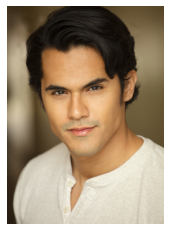

In [ ]:
# Load image
im_url = "https://images.squarespace-cdn.com/content/54d942d5e4b0c4d5e7b8e4f0/1497544777398-OW4VWOD1N0T30DACU87J/Actors-Headshots.jpg?format=1000w&content-type=image%2Fjpeg"
response = requests.get(im_url)
image = Image.open(BytesIO(response.content))
plt.imshow(image)
plt.axis('off');

In [ ]:
# Init face detector/predictor
!wget -nd https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat
landmark_path = "shape_predictor_68_face_landmarks.dat"
detector, predictor = get_face_predictor_detector(landmark_path)

--2023-03-09 06:50:29--  https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JeffTrain/selfie/master/shape_predictor_68_face_landmarks.dat [following]
--2023-03-09 06:50:29--  https://raw.githubusercontent.com/JeffTrain/selfie/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[===================>]  95.08M   233MB/s    in 0.4s    

2023-03-09 06:50:34 (233 M

In [ ]:
# Convert image to grayscale numpy
image_gray = np.array(ImageOps.grayscale(image))

# Get mustache mask and resize
mask, debug_image = get_image_mask(image_gray, detector, predictor)
mask = cv2.resize(mask,(512,512))
debug_image = cv2.resize(debug_image,(512,512))
image = cv2.resize(np.array(image),(512,512))

Found 1 face(s)
Time to get image mask:  289.56 ms


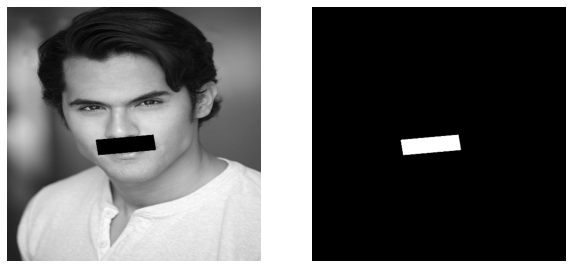

In [ ]:
# Look at debug image and mask
fig1 = plt.figure(figsize=(10,5));
ax1,ax2 = fig1.subplots(1,2);
ax1.imshow(debug_image,cmap='gray');
ax2.imshow(mask,cmap='gray'); 
ax1.axis('off');ax2.axis('off');

In [ ]:
# Define the inpainting pipeline
device = "cuda"
model_path = "stabilityai/stable-diffusion-2-inpainting"
#"runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
# Inpainting settings
prompt   = "a high quality hyper-realistic photograph of a man with a mustache, thick mustache, dark mustache, facial hair"
n_prompt = "cartoon, blurry, ugly, bad anatomy, disfigured"

cfg = 7
denoise = .8
steps = 20
num_samples = 1
generator = torch.Generator(device=device).manual_seed(np.random.randint(1e5)) # change the seed to get different results

  0%|          | 0/20 [00:00<?, ?it/s]

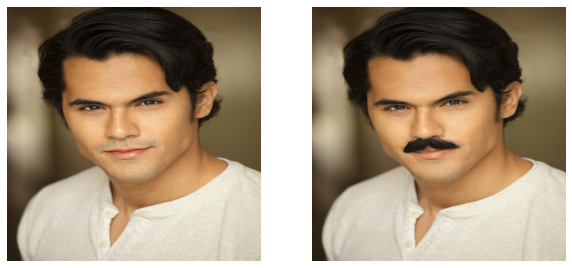

In [ ]:
# Run inpainting
images = pipe(
    height=512,
    width=512,
    prompt=prompt,
    negative_prompt=n_prompt,
    num_inference_steps=steps,
    image=Image.fromarray(image),
    mask_image=Image.fromarray(mask),
    guidance_scale=cfg,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

# Show result
images.insert(0, image)
fig1 = plt.figure(figsize=(10,5))
ax1,ax2=fig1.subplots(1,2)
ax1.imshow(images[0])
ax2.imshow(images[1])
ax1.axis('off'); ax2.axis('off');